# Introduction

In this notebook, I've used **CNN** to perform Image Classification on the Brain Tumor dataset.<br>
Since this dataset is small, if we train a neural network to it, it won't really give us a good result.<br>
Therefore, I'm going to use the concept of **Transfer Learning** to train the model to get really accurate results.

### Note

If you find this notebook helpful and intuitive, feel free to upvote it! Do give me your suggestions or opinions so that I can improve my work! I will highly appreciate it! Thank you! :)

---

# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

---

# Color

In [2]:
tf.__version__

'2.4.1'

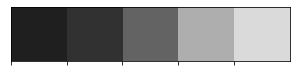

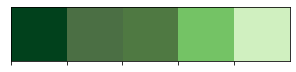

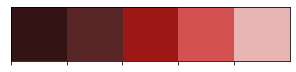

In [3]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

---

# Data Preperation

In [4]:
labels = os.listdir("/kaggle/input/maize-image-dataset/Maize/train_set")
CLASS_NAMES = labels
CLASS_NAMES

['leaf beetle',
 'healthy',
 'leaf blight',
 'grasshoper',
 'fall armyworm',
 'streak virus',
 'leaf spot']

We start off by appending all the images from the  directories into a Python list and then converting them into numpy arrays after resizing it.

In [5]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/kaggle/input/maize-image-dataset/Maize','train_set',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/kaggle/input/maize-image-dataset/Maize','test_set',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 1261/1261 [00:11<00:00, 112.60it/s]


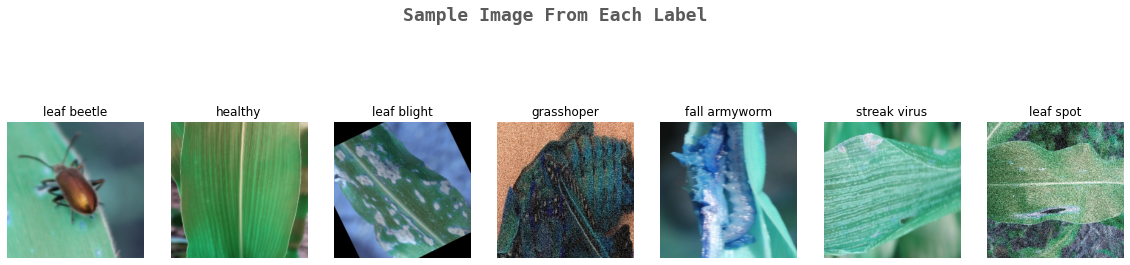

In [7]:
k=0
fig, ax = plt.subplots(1,len(CLASS_NAMES),figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [9]:
X_train.shape

(24551, 224, 224, 3)

Dividing the dataset into **Training** and **Testing** sets.

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [11]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

---

# Transfer Learning

Deep convolutional neural network models may take days or even weeks to train on very large datasets.

A way to short-cut this process is to re-use the model weights from pre-trained models that were developed for standard computer vision benchmark datasets, such as the ImageNet image recognition tasks. Top performing models can be downloaded and used directly, or integrated into a new model for your own computer vision problems.

In this notebook, I'll be using the **EfficientNetB0** model which will use the weights from the **ImageNet** dataset.

The include_top parameter is set to *False* so that the network doesn't include the top layer/ output layer from the pre-built model which allows us to add our own output layer depending upon our use case!

In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16711680/16705208 [==============================] - 0s 0us/step


**GlobalAveragePooling2D** -> This layer acts similar to the Max Pooling layer in CNNs, the only difference being is that it uses the Average values instead of the Max value while *pooling*. This really helps in decreasing the computational load on the machine while training.
<br><br>
**Dropout** -> This layer omits some of the neurons at each step from the layer making the neurons more independent from the neibouring neurons. It helps in avoiding overfitting. Neurons to be ommitted are selected at random. The **rate** parameter is the liklihood of a neuron activation being set to 0, thus dropping out the neuron

**Dense** -> This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the **softmax** function which is a generalization of the sigmoid function.

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(len(CLASS_NAMES),activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

We finally compile our model.

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

**Callbacks** -> Callbacks can help you fix bugs more quickly, and can help you build better models. They can help you visualize how your model’s training is going, and can even help prevent overfitting by implementing early stopping or customizing the learning rate on each iteration.<br><br>
By definition, "A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training."

In this notebook, I'll be using **TensorBoard, ModelCheckpoint and ReduceLROnPlateau** callback functions

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("maize-effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

---

# Training The Model

**Note**: The training takes alot of time! ~ 2 hours for me (Using CPU)<br>
Barely took 5 minutes with the GPU.

In [18]:
history = model.fit(X_train,y_train,validation_split=0.2, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
491/491 [==============================] - 123s 224ms/step - loss: 0.7924 - accuracy: 0.7070 - val_loss: 0.5254 - val_accuracy: 0.8134

Epoch 00001: val_accuracy improved from -inf to 0.81339, saving model to maize-effnet.h5
Epoch 2/12
491/491 [==============================] - 107s 217ms/step - loss: 0.3935 - accuracy: 0.8560 - val_loss: 0.5248 - val_accuracy: 0.8279

Epoch 00002: val_accuracy improved from 0.81339 to 0.82790, saving model to maize-effnet.h5
Epoch 3/12
491/491 [==============================] - 107s 217ms/step - loss: 0.2990 - accuracy: 0.8889 - val_loss: 0.4733 - val_accuracy: 0.8266

Epoch 00003: val_accuracy did not improve from 0.82790
Epoch 4/12
491/491 [==============================] - 107s 217ms/step - loss: 0.2347 - accuracy: 0.9126 - val_loss: 0.4593 - val_accuracy: 0.8432

Epoch 00004: val_accuracy improved from 0.82790 to 0.84318, saving model to maize-effnet.h5
Epoch 5/12
491/491 [==============================] - 107s 218ms/step - loss: 0.2068

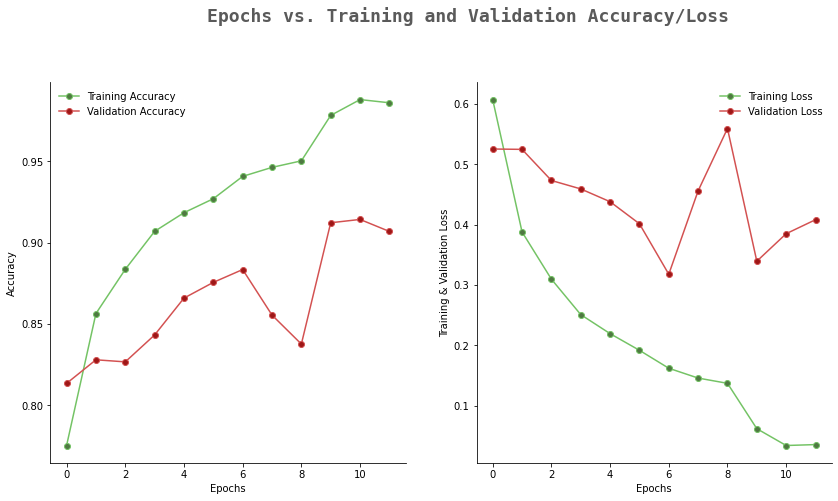

In [19]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 5 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [20]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

---

# Evaluation

In this, <br>
0 - Anthracnose<br>
1 - Gumosis<br>
2 - Healthy<br>
3 - Leaf Miner<br>
4 - Red Rust<br>

In [21]:
cr = classification_report(y_test_new,pred)
cmetric = confusion_matrix(y_test_new,pred)

In [22]:
raw_data = cr.split("\n")
precision = []
recall = []
f1_score = []
for line in raw_data[2:-5]:
    line = line.split()
    precision.append(float(line[1]))
    recall.append(float(line[2]))
    f1_score.append(float(line[3]))

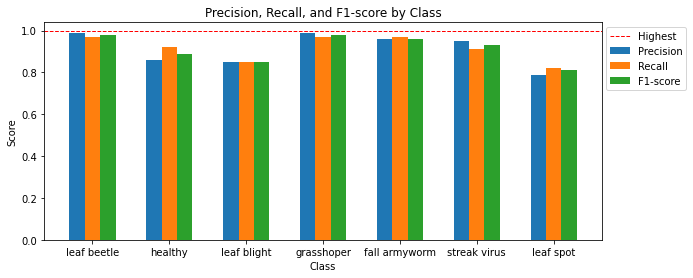

In [23]:


# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 4))
x = range(len(labels))
width = 0.2

plt.bar(x, precision, width, label='Precision')
plt.bar([i + width for i in x], recall, width, label='Recall')
plt.bar([i + 2 * width for i in x], f1_score, width, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score by Class')
plt.xticks([i + width for i in x], labels)
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Highest')

plt.legend(loc='upper right', bbox_to_anchor=(1.16, 1), shadow=False, ncol=1)
plt.show()


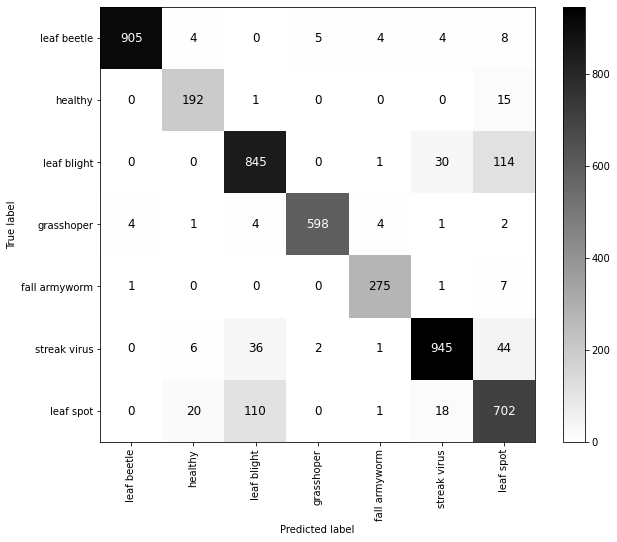

In [24]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

CLASS_NAMES = labels
# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cmetric, display_labels=CLASS_NAMES)
disp.plot(ax=ax, cmap='binary')

# Customize x-axis and y-axis ticks with class names
ax.set_xticks(range(len(CLASS_NAMES)))  # Set x-ticks to match the number of classes
ax.set_xticklabels(CLASS_NAMES, rotation=90)  # Set x-tick labels as class names with 90-degree rotation

ax.set_yticks(range(len(CLASS_NAMES)))  # Set y-ticks to match the number of classes
ax.set_yticklabels(CLASS_NAMES)  # Set y-tick labels as class names

# Set font size for the text in the plot
for text in ax.texts:
    text.set_fontsize(12)

# Remove axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.grid(False)
# Show plot
plt.show()

---

In [25]:
test_predictions = model.predict(X_test)

In [26]:
y_val_indexes = np.array([val.argmax() for val in tqdm(y_test)])
y_val_indexes[:5]

100%|██████████| 4911/4911 [00:00<00:00, 466128.69it/s]


array([5, 0, 6, 4, 6])

In [27]:
y_test_classes = np.argmax(test_predictions, axis=1)
y_test_classes[0:5]

array([2, 0, 2, 5, 5])

In [28]:
y_test_classes.shape, y_val_indexes.shape

((4911,), (4911,))

In [29]:
y_true = y_val_indexes
accuracy = accuracy_score(y_true, y_test_classes)
accuracy

0.9085725921400937

In [30]:
cr = classification_report(y_true, y_test_classes)
cmetric = confusion_matrix(y_true, y_test_classes)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       930
           1       0.86      0.92      0.89       208
           2       0.85      0.85      0.85       990
           3       0.99      0.97      0.98       614
           4       0.96      0.97      0.96       284
           5       0.95      0.91      0.93      1034
           6       0.79      0.82      0.81       851

    accuracy                           0.91      4911
   macro avg       0.91      0.92      0.92      4911
weighted avg       0.91      0.91      0.91      4911



In [31]:
raw_data = cr.split("\n")
precision = []
recall = []
f1_score = []
for line in raw_data[2:-5]:
    line = line.split()
    precision.append(float(line[1]))
    recall.append(float(line[2]))
    f1_score.append(float(line[3]))

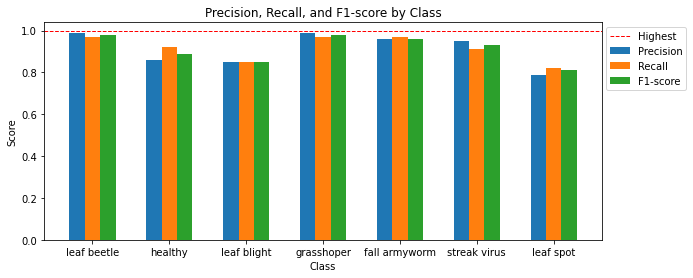

In [32]:
# Create lists for precision, recall, and F1-score

# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 4))
x = range(len(labels))
width = 0.2

plt.bar(x, precision, width, label='Precision')
plt.bar([i + width for i in x], recall, width, label='Recall')
plt.bar([i + 2 * width for i in x], f1_score, width, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score by Class')
plt.xticks([i + width for i in x], labels)
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Highest')

plt.legend(loc='upper right', bbox_to_anchor=(1.16, 1), shadow=False, ncol=1)
plt.show()


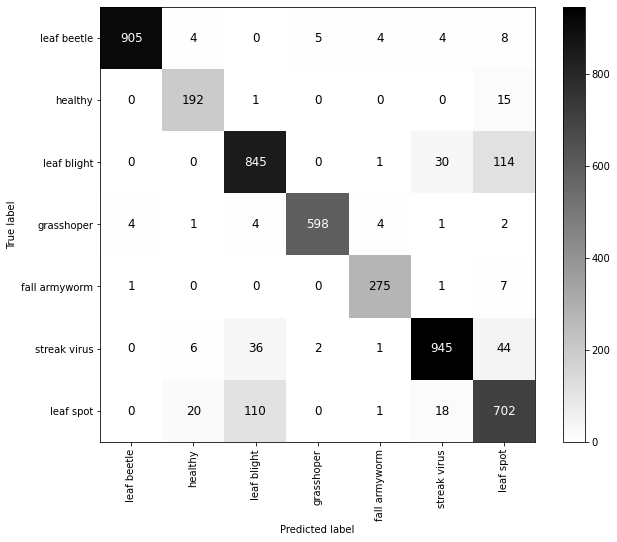

In [33]:
CLASS_NAMES = labels
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cmetric, display_labels=CLASS_NAMES)
disp.plot(ax=ax, cmap='binary')

# Customize x-axis and y-axis ticks with class names
ax.set_xticks(range(len(CLASS_NAMES)))  # Set x-ticks to match the number of classes
ax.set_xticklabels(CLASS_NAMES, rotation=90)  # Set x-tick labels as class names with 90-degree rotation

ax.set_yticks(range(len(CLASS_NAMES)))  # Set y-ticks to match the number of classes
ax.set_yticklabels(CLASS_NAMES)  # Set y-tick labels as class names

# Set font size for the text in the plot
for text in ax.texts:
    text.set_fontsize(12)

# Remove axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

plt.grid(False)
# Show plot
plt.show()

In [34]:
# First prediction
index = 40
print(test_predictions[index])
print(f"Max value (probability of prediction): {np.max(test_predictions[index])}")
print(f"Sum: {np.sum(test_predictions[index])}")
print(f"Max index: {np.argmax(test_predictions[index])}")
print(f"Predicted label: {CLASS_NAMES[np.argmax(test_predictions[index])]}")

[1.3277704e-14 1.0628674e-15 1.0000000e+00 1.9544072e-13 2.2578418e-11
 3.1744257e-11 5.2388264e-11]
Max value (probability of prediction): 1.0
Sum: 1.0
Max index: 2
Predicted label: leaf blight


In [35]:
CLASS_NAMES[4]

'fall armyworm'

In [36]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return CLASS_NAMES[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(test_predictions[81])
pred_label

'leaf blight'

In [37]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], CLASS_NAMES[labels[n]], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image.astype("uint8"))
  plt.xticks([])
  plt.yticks([])
    
  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

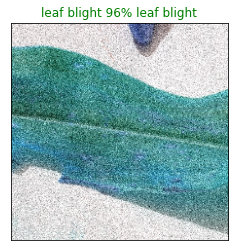

In [38]:
plot_pred(prediction_probabilities=test_predictions,
          labels=y_val_indexes,
          images=X_test,
          n=2400)
plt.show()

In [39]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)
  # Find the top  prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[::-1]

#   print(top_10_pred_indexes)
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = top_10_pred_indexes
  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

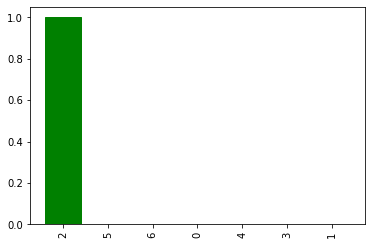

In [40]:
plot_pred_conf(prediction_probabilities=test_predictions,
               labels=y_val_indexes,
               n=8)

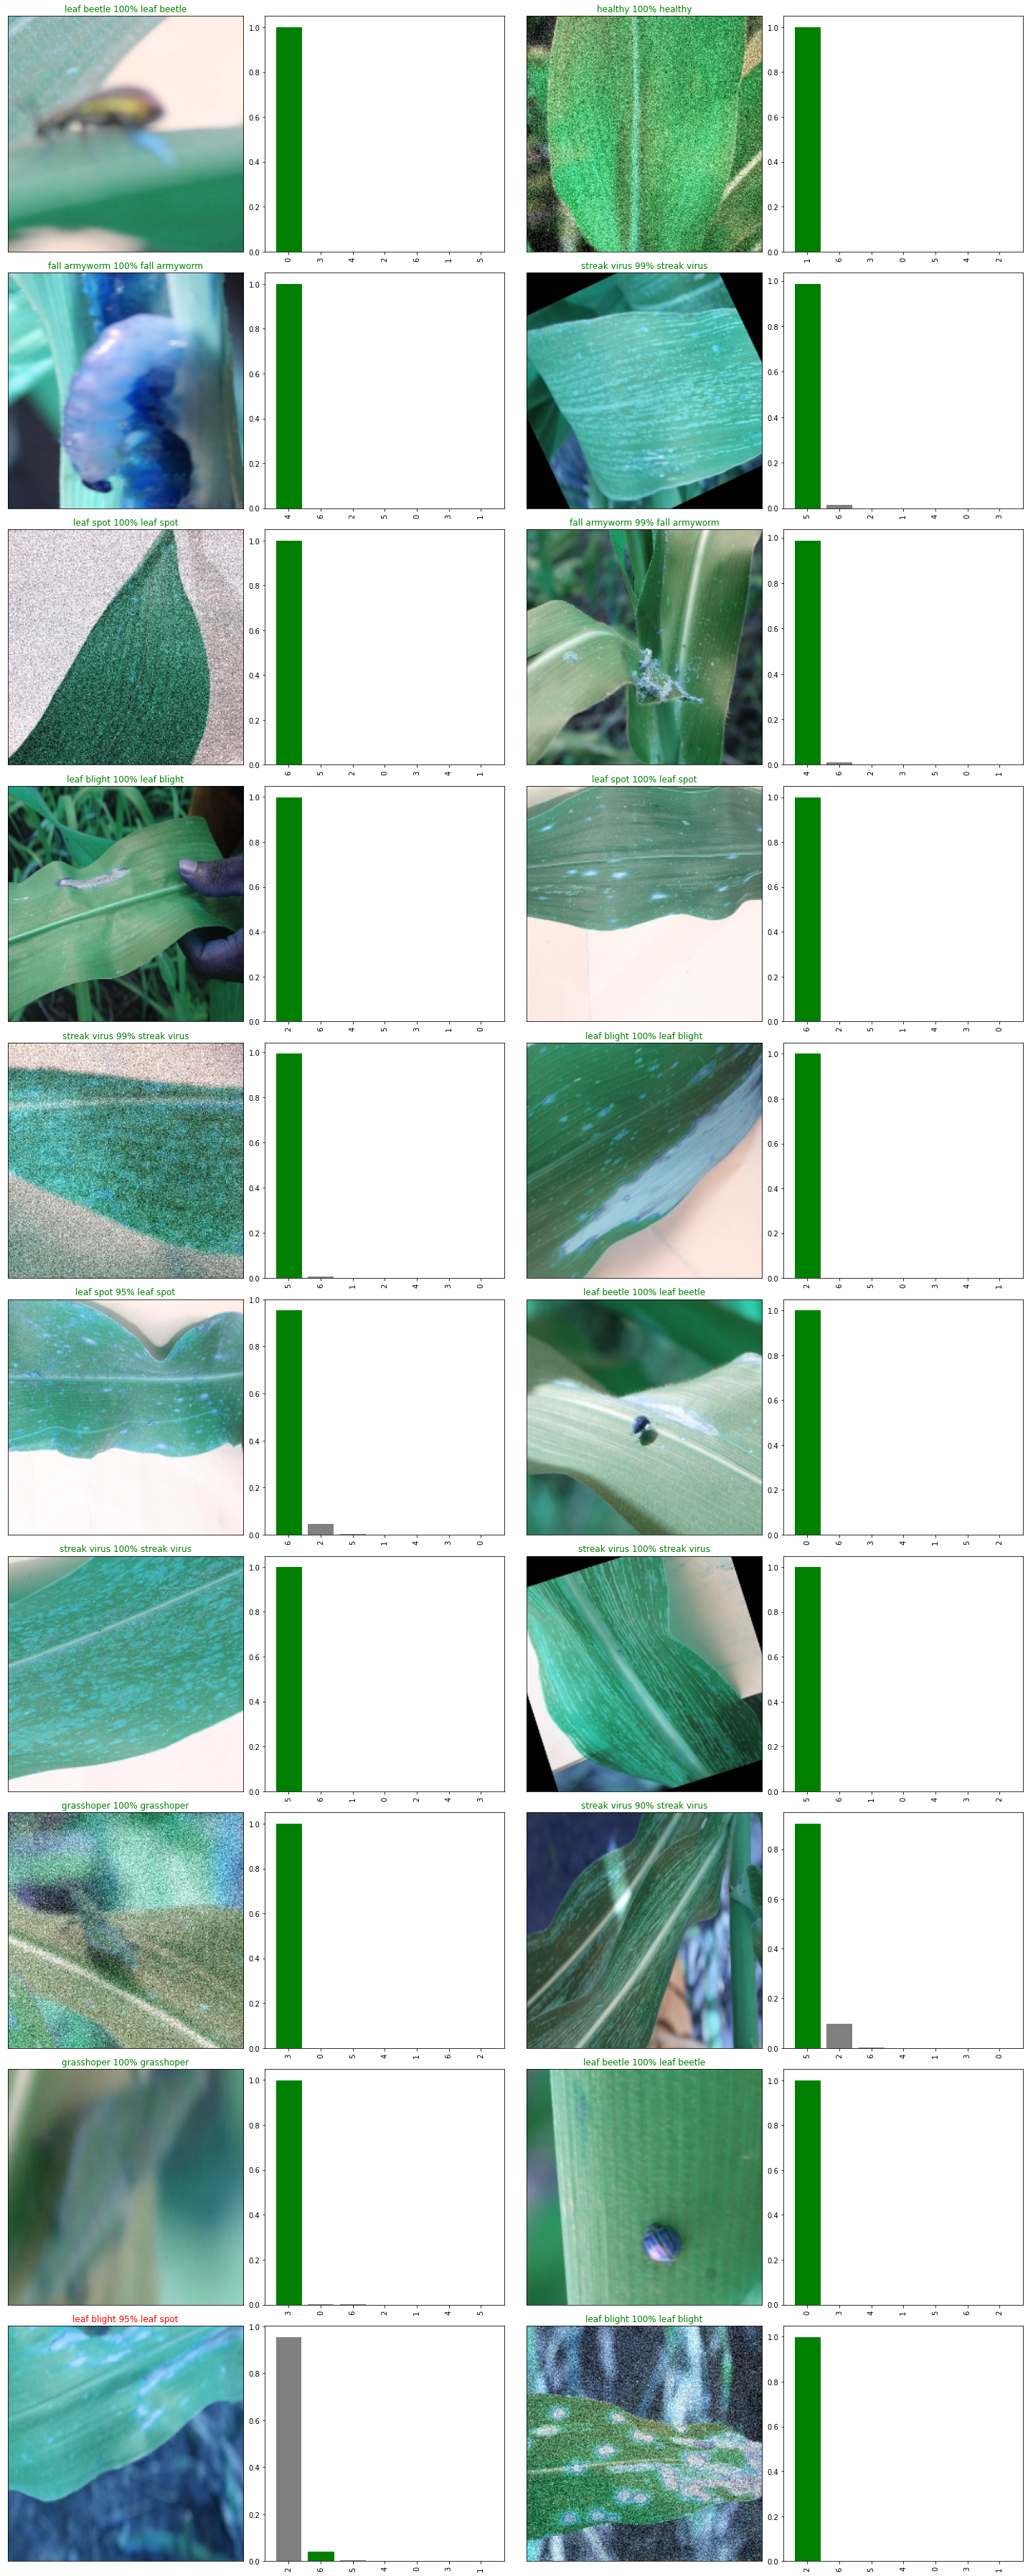

In [41]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 10
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=test_predictions,
            labels=y_val_indexes,
            images=X_test,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=test_predictions,
                 labels=y_val_indexes,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Conclusion

In this notebook, I performed Image Classification with the help of CNN using Transfer Learning which gave an accuracy of around 98%.<br>
I also made widgets which can make predictions on an image from your local machine!

---

# <center>Thank You!